<a href="https://colab.research.google.com/github/swadhwa5/MLFinalProject/blob/main/SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models For Machine Learning

## Model Implementation: LeNet with 3 Channels

LeNet was one of the first convolutional neural network (CNN) models used on 28x28 black and white images. While it is simple, it was one of the first uses of the backpropgation algorithm in practical applications: specifically, reading handwritten numbers. In 1990, there was an error rate of 1% and rejection rate of about 9%. The model structure is as follows:
1. 2 convolutional layers
2. 2 pooling layers
3. 3 fully-connected

In this implementation, we make the slight modifications to this standard network structure as follows:
1. Add dropout layers for regularization
2. Input 32x32 sized images
3. Input 3 channels (RGB images).
4. Input features to fully-connected layers

LeCun, Y.; Boser, B.; Denker, J. S.; Henderson, D.; Howard, R. E.; Hubbard, W. & Jackel, L. D. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation, 1(4):541-551.[1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Loading images
import imghdr
from PIL import Image
from os import listdir

# Image preprocessing
import torchvision
import torchvision.transforms as transforms

# For model implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

# For classes
import string

In [2]:
class LeNet(nn.Module):
    def __init__(self, num_classes=26, num_features=402):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear = nn.Sequential(
            nn.Linear(16 * 5 * 5 + num_features, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x, feature):
        x = self.conv_layer(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.cat((x, feature), 1)
        x = self.linear(x)
        return x

### Training the model:

Below is the network training function. This implements forward and backward propagation to update model parameters.

In [3]:
# Train the model parameters
def train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer, model, num_images, n=20):

  epochs = []
  train_losses = []
  dev_accuracies = []
  for epoch in range(n):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, features, labels]
        inputs, features, labels = data
        labels = labels.type(torch.LongTensor)
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          features = features.cuda()  
          labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_acc, train_loss = approx_train_acc_and_loss(model, train_data, train_labels)
    dev_acc, dev_loss = dev_acc_and_loss(model, dev_data, dev_labels)
    epochs.append(epoch)
    train_losses.append(train_loss)
    dev_accuracies.append(dev_acc)
    step_metrics = {
            'step': epoch, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }
    if epoch % 2 == 0:
      print(f"On step {epoch}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")



  print('Finished Training')
  return epochs, train_losses, dev_accuracies

### Testing the model

Below is the function for testing the model. This function will output the testing result based on the testloader. The function also takes a "num_display" argument for how many incorrect images we want to visualize.

In [4]:
# Test the model on help out dev set
def test_model(testloader, labels1, test_data, model, num_display=0):
    correct = 0
    total = 0
    misclass_ind = []
    incorrect_imgs = []
    incorrect_labels = []
    predicted_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, features, labels = data
            if torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()
              features = features.cuda()
            # calculate outputs by running images through the network
            outputs = model(images, features)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() # Calculate number correct
            if ((predicted != labels).sum().item()) > 0:
                incorrect = predicted - labels
                for i in range(len(incorrect)):
                    if incorrect[i] != 0:
                        incorrect_imgs.append(images[i])
                        misclass_ind.append(total + i)
                        incorrect_labels.append(labels[i])
                        predicted_labels.append(predicted[i])

                    
            total += labels.size(0) # for each batch (size=4), predict the labels

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    incorrect_images = torch.Tensor(np.asarray([test_data[i][0] for i in misclass_ind])).cpu()
    if num_display < len(incorrect_images):
      incorrect_images = incorrect_images[0:num_display]
      incorrect_imgs = incorrect_imgs[0:num_display]
    if len(incorrect_images) != 0:
      imshow(torchvision.utils.make_grid(incorrect_imgs))
      print("Actual labels: " +
            ' '.join(f'{classes[incorrect_labels[j]]:5s}' for j in range(num_display)))
      print("predicted labels: " +
            ' '.join(f'{classes[predicted_labels[j]]:5s}' for j in range(num_display)))

    return correct, total

### Utils:

Here are additional Functions related to visualizing images, training Loss, validation, dev loss, validation, etc.

In [5]:
def imshow(img):
  # Unnormalize the image before showing!
    """Shows a specific image based on the input data

    Args:
        img (np.ndarray): A normalized image with values [0, 1] to display
                          [3, x_dim, y_dim] input shape

    Returns:
        N/A
    """
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                  ])
    img = invTrans(img.cpu())
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    """Calculate the simple accuracy given two numpy vectors, each with int values
    corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    N = len(y)   
    number_correct = N - np.count_nonzero(y - y_hat)
    accuracy = number_correct / N
    return accuracy


def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    idxs = np.random.choice(len(train_data), 1, replace=False)
    x = torch.from_numpy(np.asarray([train_data[idxs[0]][0]]).astype(np.float32))
    features = torch.from_numpy(np.asarray([train_data[idxs[0]][1]]).astype(np.float32))
    y = torch.from_numpy(train_labels[idxs])
    y = y.long()
   
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
      features = features.cuda()
    logits = model(x, features)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(train_labels[idxs], y_pred.cpu().numpy()), loss.item()


def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    dev_labels = np.asarray(dev_labels)

    x = torch.from_numpy(np.asarray([c[0] for c in dev_data]).astype(np.float32))
    features = torch.from_numpy(np.asarray([c[1] for c in dev_data]).astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(int))
    y = y.long()
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
      features = features.cuda()
    logits = model(x, features)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    y_pred = y_pred.cpu()
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

def plot_train_stats(epochs, train_losses, dev_accuracies):
  fig, ax = plt.subplots(1, 2, figsize=(10,5))
  ax[0].plot(epochs, train_losses)
  ax[0].set_title("Training Loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Training Loss")
  ax[0].grid()

  ax[1].plot(epochs, dev_accuracies)
  ax[1].set_title("Development Accuracy")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Development Accuracy")
  ax[1].grid()

  plt.tight_layout()

## Data loading

In [6]:
def loadImages(path):
    """Shows a specific image based on the input data

    Args:
        path (string): Path to a folder of .png files. Let #=dataset num, l = letter represented, v=variation, a=augmentation
                       Must be structured s.t. hand#_l_v_a.png

    Returns:
        imgs (list): The list of images from a specified dataset
        labels (list): The list of labels corresponding to each image index

    """
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList: # iterate over all images in the folder
        if imghdr.what(path + image) == 'png':
            if (image[6].isalpha()): # 6th position is the letter
                img = Image.open(path + image)
                imgs.append(img)
                labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

def applyTransforms(imgs, crop_size, resize):
    """Applies crop and resizing images to each input image

    Args:
        imgs (list): The list of images from a specified dataset
        resize (int): An integer representing how to first scale the image prior to
                      cropping
        crop_size (int): An integer representing the center rectangle radius
                         to crop each provided image


    Returns:
        imgs (list): The list of images from a specified dataset
        labels (list): The list of labels corresponding to each image index

    """
    # Define the necessary preprocessing transforms
    num_imgs = len(imgs)
    preprocess = transforms.Compose([
      transforms.Resize(resize), # Hyperparameter
      transforms.CenterCrop(crop_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create tensor array
    transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
    for i in range(num_imgs):
      temp = preprocess(imgs[i])
      transforms_array[i,:,:,:] = temp
    
    return transforms_array

In [7]:
def train_dev_test_datasets(transforms_array, labels, dev_split=0.1, test_split=0.1, batch_size=4):
  """Create the trainloader, devloader, and testloader

  Args:
      transforms_array (Tensor): All of the pre-processed images (n, 3, 32, 32)
      labels (list of strings): The ground truth labels
      test_split (float): How to split the training, dev, and test data. Will be 
                          1-test_split, test_split/2, test_split/2, respectively
      batch_size (int): the batch size for the train, dev, test loaders

  Returns:
      train_data (list of np.ndarrays): List of training images after split
      train_labels (list): The list of labels corresponding to each train image index
      train_data (list of np.ndarrays): List of dev images after split
      train_labels (list): The list of labels corresponding to each dev image index  
      train_data (list of np.ndarrays): List of test images after split
      train_labels (list): The list of labels corresponding to each test image index

  """
  ## Create the training dataand trainloader
  train_data, dev_data, train_labels, dev_labels = train_test_split(transforms_array, labels, test_size=(dev_split+test_split), random_state=42)
  dev_data, test_data, dev_labels, test_labels = train_test_split(dev_data, dev_labels, test_size=(test_split/(dev_split+test_split)), random_state=42)

  # Save the labels as np.ndarrays()
  train_labels = np.asarray(train_labels)
  dev_labels = np.asarray(dev_labels)
  test_labels = np.asarray(test_labels)

  return [train_data, train_labels, dev_data, dev_labels, test_data, test_labels]


def create_dataloaders(dataset, labels, shuffle=True, batch_size=4):
  """Create the train, dev, and test data + labels

  Args:

      test_split (float): How to split the training, dev, and test data. Will be 
                          1-test_split, test_split/2, test_split/2, respectively
      batch_size (int): the batch size for the train, dev, test loaders

  Returns:
      trainloader (torch.utils.data.DataLoader): Dataloader for training data
      trainloader (torch.utils.data.DataLoader): Dataloader for training data
      trainloader (torch.utils.data.DataLoader): Dataloader for training data
  """

  data_and_labels = []
  for i in range(len(dataset)):
    sample = (torch.Tensor(train_data[i][0][:, :, :]), torch.Tensor(train_data[i][1]), train_labels[i])
    data_and_labels.append(sample)

  dataloader = torch.utils.data.DataLoader(data_and_labels, batch_size=batch_size,
                                            shuffle=shuffle, num_workers=2)
  
  ## Create the Test data and testloader


  return dataloader


In [8]:
orig_data_path = "./handgesturedataset_part1/"
aug_data_path = "./FinalImages/"
mult_augments_path = "./Mult_Augments/"

In [9]:
### Get all the images + labels into folder... this takes a while

orig_imgs, orig_labels = loadImages(orig_data_path)
print(f"Total number of images in Orig Dataset is: {len(orig_imgs)}")

orig_alpha = np.load("./features/a.npy")
orig_convex = np.load("./features/c.npy")
orig_cvx = np.load("./features/cvx.npy")
orig_htb = np.load("./features/htb.npy")

orig_features = np.append(orig_alpha, orig_convex, axis=1)
orig_features = np.append(orig_features, orig_cvx.reshape(orig_convex.shape[0], 1), axis=1)
orig_features = np.append(orig_features, orig_htb.reshape(orig_convex.shape[0], 1), axis=1)

print(f"Features Shape for Orig Dataset is: {orig_features.shape}")

Total number of images in Orig Dataset is: 650
Features Shape for Orig Dataset is: (650, 402)


In [10]:
aug_imgs, aug_labels = loadImages(aug_data_path)
print(f"Total number of images in Aug Dataset is: {len(aug_imgs)}")

aug_alpha = np.load("./features/aFinal.npy")
aug_convex = np.load("./features/cFinal.npy")
aug_cvx = np.load("./features/cvxFinal.npy")
aug_htb = np.load("./features/htbFinal.npy")

aug_features = np.append(aug_alpha, aug_convex, axis=1)
aug_features = np.append(aug_features, aug_cvx.reshape(aug_convex.shape[0], 1), axis=1)
aug_features = np.append(aug_features, aug_htb.reshape(aug_convex.shape[0], 1), axis=1)

print(f"Features Shape for Orig Dataset is: {aug_features.shape}")

Total number of images in Aug Dataset is: 3900
Features Shape for Orig Dataset is: (3900, 402)


In [11]:
mult_aug_imgs, mult_aug_labels = loadImages(mult_augments_path)
print(f"Total number of images in Mult_Aug Dataset is: {len(mult_aug_imgs)}")

mult_aug_alpha = np.load("./features/aMult.npy")
mult_aug_convex = np.load("./features/cMult.npy")
mult_aug_cvx = np.load("./features/cvxMult.npy")
mult_aug_htb = np.load("./features/htbMult.npy")

mult_aug_features = np.append(mult_aug_alpha, mult_aug_convex, axis=1)
mult_aug_features = np.append(mult_aug_features, mult_aug_cvx.reshape(mult_aug_convex.shape[0], 1), axis=1)
mult_aug_features = np.append(mult_aug_features, mult_aug_htb.reshape(mult_aug_convex.shape[0], 1), axis=1)

print(f"Features Shape for Orig Dataset is: {mult_aug_features.shape}")

Total number of images in Mult_Aug Dataset is: 650
Features Shape for Orig Dataset is: (650, 402)


## Training, testing, and analysis!

**Note**: Assume google drive has the dataset folders in the path specified.
1. "Data_full" -> One dataset in the handgestures dataset of the images
2. "FinalImages" -> Dataset with only single augmentation data
3. "Mult_Augments" -> Dataset with multiple augmentations

In [12]:
### Add additional parameters for SimpleCNN
batch_size = 4
channels = 3
xdim = 32
ydim = 32
classes = list(string.ascii_uppercase) # A-Z

### Train/Test on Normal Dataset

#### Train

In [13]:


# Preprocess the data to feed into LeNet 32x32
transforms_array_train = applyTransforms(orig_imgs, crop_size=xdim, resize=15)

orig_data_list = []
for i in range(transforms_array_train.shape[0]):
    orig_data_list.append((transforms_array_train[i], orig_features[i]))


train_data, train_labels, dev_data, dev_labels, test_data, test_labels = train_dev_test_datasets(orig_data_list, orig_labels, batch_size=batch_size)

trainloader = create_dataloaders(train_data, train_labels, shuffle=True, batch_size=4)


In [14]:
lenet_no_aug = LeNet()

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_no_aug.parameters(), lr=lr) # Adam converges faster; generally used

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_no_aug.to(device);

In [15]:
epochs, train_losses, dev_accuracies = train_model(trainloader, train_data, train_labels, dev_data, dev_labels, 
                                                   criterion, optimizer, lenet_no_aug, num_images=len(train_data), n=30)


On step 0:	Train loss 4.504528999328613	|	Dev acc is 0.09230769230769231
On step 2:	Train loss 0.5638648867607117	|	Dev acc is 0.6461538461538462
On step 4:	Train loss 0.055464066565036774	|	Dev acc is 0.9538461538461539
On step 6:	Train loss 0.027203645557165146	|	Dev acc is 0.9230769230769231
On step 8:	Train loss 0.01912253350019455	|	Dev acc is 0.9692307692307692
On step 10:	Train loss 0.00035148640745319426	|	Dev acc is 0.9538461538461539
On step 12:	Train loss 0.03411271795630455	|	Dev acc is 0.8923076923076924
On step 14:	Train loss 1.1920928244535389e-07	|	Dev acc is 0.9846153846153847
On step 16:	Train loss 7.915183232398704e-05	|	Dev acc is 0.9538461538461539
On step 18:	Train loss 0.001453891978599131	|	Dev acc is 0.9846153846153847
On step 20:	Train loss 0.0030544791370630264	|	Dev acc is 0.9846153846153847
On step 22:	Train loss 7.748573807475623e-06	|	Dev acc is 0.9846153846153847
On step 24:	Train loss 0.0011510183103382587	|	Dev acc is 1.0
On step 26:	Train loss 2.07422

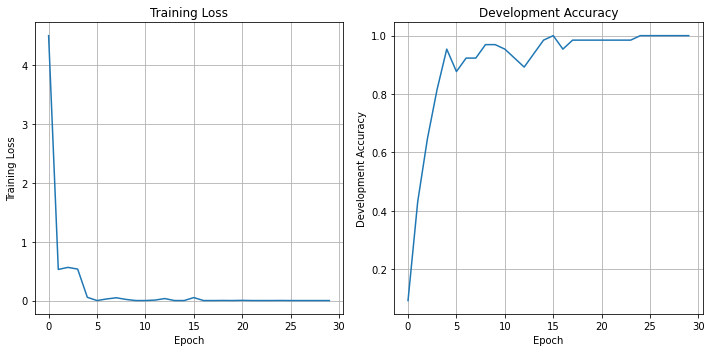

In [16]:
plot_train_stats(epochs, train_losses, dev_accuracies)

#### Test

Now that the model is built, it's time to test it on the held-out testing data

In [17]:
testloader = create_dataloaders(test_data, test_labels, shuffle=True, batch_size=4)
print("Evalating on the held-out test set...")
correct, total = test_model(testloader, test_labels, test_data, lenet_no_aug, num_display=5)
print(f"Correct: {correct} \nTotal: {total}")

Evalating on the held-out test set...
Accuracy of the network on the 65 test images: 100 %
Correct: 65 
Total: 65


In [18]:
# Save the model!
torch.save(lenet_no_aug.state_dict(), "./models/lenet_no_aug_feat_650")

### Now, try the same process but with the data augmented dataset!

This will allow us to determine the effect of data augmentation on testing accuracy

#### Train

In [30]:
# Preprocess the data to feed into LeNet 32x32
transforms_array_train_aug = applyTransforms(aug_imgs, crop_size=xdim, resize=35)
aug_data_list = []
for i in range(transforms_array_train_aug.shape[0]):
    aug_data_list.append((transforms_array_train_aug[i], aug_features[i]))

train_data, train_labels, dev_data, dev_labels, test_data_aug, test_labels_aug = train_dev_test_datasets(aug_data_list, aug_labels, test_split=0.2, batch_size=batch_size)

trainloader = create_dataloaders(train_data, train_labels, shuffle=True, batch_size=4)

In [31]:
lenet_with_aug = LeNet()

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_with_aug.parameters(), lr=lr) # Adam converges faster; generally used

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_with_aug.to(device);

In [32]:
epochs, train_losses, dev_accuracies = train_model(trainloader, train_data, train_labels, dev_data, dev_labels, 
                                                   criterion, optimizer, lenet_with_aug, num_images=len(train_data), n=30)


On step 0:	Train loss 1.9619427919387817	|	Dev acc is 0.3076923076923077
On step 2:	Train loss 1.2807178497314453	|	Dev acc is 0.5769230769230769
On step 4:	Train loss 0.3135908544063568	|	Dev acc is 0.658974358974359
On step 6:	Train loss 1.1808127164840698	|	Dev acc is 0.7384615384615385
On step 8:	Train loss 1.946564793586731	|	Dev acc is 0.7589743589743589
On step 10:	Train loss 0.025478828698396683	|	Dev acc is 0.8153846153846154
On step 12:	Train loss 0.6513949632644653	|	Dev acc is 0.7128205128205128
On step 14:	Train loss 3.513310432434082	|	Dev acc is 0.7307692307692307
On step 16:	Train loss 0.9036957025527954	|	Dev acc is 0.8025641025641026
On step 18:	Train loss 0.013830776326358318	|	Dev acc is 0.8461538461538461
On step 20:	Train loss 0.0014552014181390405	|	Dev acc is 0.7923076923076923
On step 22:	Train loss 0.0	|	Dev acc is 0.7974358974358975
On step 24:	Train loss 0.0	|	Dev acc is 0.7897435897435897
On step 26:	Train loss 4.751710414886475	|	Dev acc is 0.8205128205128

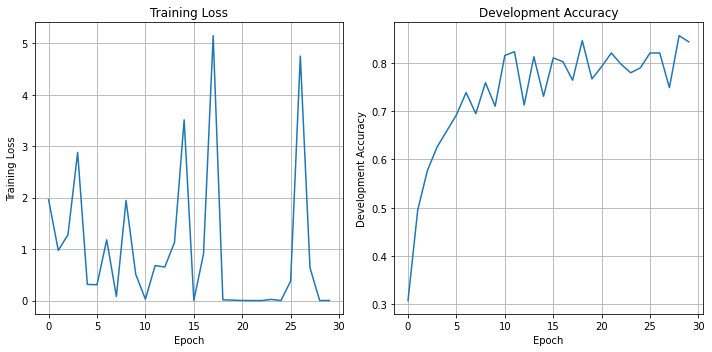

In [33]:
plot_train_stats(epochs, train_losses, dev_accuracies)

#### Test

Evalating on the held-out test set...
Accuracy of the network on the 781 test images: 93 %


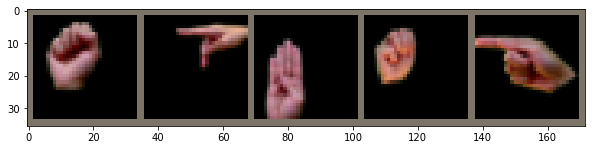

Actual labels: S     P     B     M     G    
predicted labels: T     J     R     E     H    
Correct: 731 
Total: 781


In [38]:
testloader = create_dataloaders(test_data_aug, test_labels_aug, shuffle=True, batch_size=4)
print("Evalating on the held-out test set...")
correct, total = test_model(testloader, test_labels_aug, test_data_aug, lenet_with_aug, num_display=5)
print(f"Correct: {correct} \nTotal: {total}")


In [24]:
# Save the model!
torch.save(lenet_with_aug.state_dict(), "./models/lenet_with_aug_feat_3900")

### Test on Data-Augmented Dataset

In [25]:
transforms_array_mult_aug_data = applyTransforms(mult_aug_imgs, crop_size=32, resize=35)

mult_aug_data_list = []
for i in range(transforms_array_mult_aug_data.shape[0]):
    mult_aug_data_list.append((transforms_array_mult_aug_data[i], mult_aug_features[i]))

mult_aug_testloader = create_dataloaders(mult_aug_data_list, mult_aug_labels)

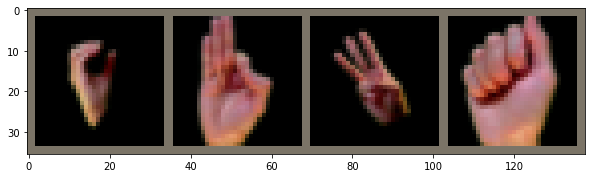

labels: C     F     W     A    


In [26]:
# Visualize how some of the images look after multiple augmentations
dataiter = iter(mult_aug_testloader)
images, features, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


#### Model trained on No Augmentations

Evalating on the held-out test set...
Accuracy of the network on the 650 test images: 35 %


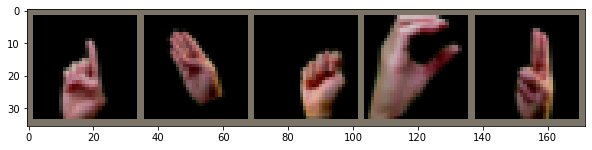

Actual labels: D     B     T     C     U    
predicted labels: L     Z     Z     K     K    
Correct: 228 
Total: 650


In [27]:
# Let's use the no augmentation to observe training time
lenet_no_aug = LeNet()
lenet_no_aug.load_state_dict(torch.load("./models/lenet_no_aug_feat_650"))
lenet_no_aug.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_no_aug.to(device);

print("Evalating on the held-out test set...")
correct, total = test_model(mult_aug_testloader, mult_aug_labels, transforms_array_mult_aug_data, lenet_no_aug, num_display=5)
print(f"Correct: {correct} \nTotal: {total}")



#### Model trained on Single Augmentations

Evalating on the held-out test set...
Accuracy of the network on the 650 test images: 95 %


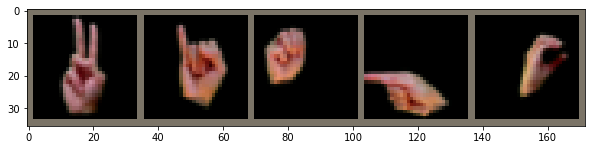

Actual labels: V     J     M     G     C    
predicted labels: R     I     Q     F     Q    
Correct: 621 
Total: 650


In [28]:
# Let's use the no augmentation to observe training time
lenet_no_aug = LeNet()
lenet_no_aug.load_state_dict(torch.load("./models/lenet_with_aug_feat_3900"))
lenet_no_aug.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_no_aug.to(device);

print("Evalating on the held-out test set...")
correct, total = test_model(mult_aug_testloader, mult_aug_labels, transforms_array_mult_aug_data, lenet_with_aug, num_display=5)
print(f"Correct: {correct} \nTotal: {total}")

